<h1><center>Лабораторная работа № 4</center></h1>
<h3><center>"Логистическая регрессия"</center></h3>

Необходимо решить задачу предсказания обнаружения присутствия людей в помещении. Задача решается в рамках платформы онлайн-конкурсов по машинному обучению TrainMyData.

**1\. Провести предподготовку данных**

(Обязательно) Здесь можно использовать отличный туториал, предоставляемый на сайте. При защите нужно уметь отвечать на все вопросы, связанные с кодом.

Результатом выполнения этого пункта является блок ячеек или скрипт предобработки данных

**2\. Обучить модель из sklearn**

Следующим шагом необходимо обучить модель логистической регрессии. Для этого нужно использовать класс LogisticRegression из sklearn.

Получить предсказания модели на валидационной части выборки. Оценить результат по метрике Accuracy.

**3\. Реализовать логистическую регрессию самостоятельно**

На этом шаге необходимо реализовать модель логистической регрессии, используя python самостоятельно. Для начала можно реализовать не векторный вариант. То есть при обучении все параметры обновлять в цикле. Этот пункт можно пропустить и переходить сразу к векторному виду, но ТОЛЬКО, если вы понимаете, как делать.

**4\. Реализовать логистическую регрессию в векторном виде**

Преобразовать код из пункта 3 в векторный формат. То есть обновление всех параметров должно происходить одновременно без циклов. Проверить, что ваш результат совпадает с результатом модели из scikit-learn.

### Решение:

# Импортирование модулей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

####  Подключаем встроенное построение графиков при помощи jupyter notebook

In [2]:
%matplotlib inline

# Константы

In [3]:
COMPETITION_FOLDER_PATH = '/home/glebdom4/.trainmydata/competitions/occupancy-detection'
DATASET_TRAIN_FILE_NAME = 'train.csv'
DATASET_TEST_FILE_NAME = 'test.csv'
SUBMISSION_FILE_NAME = 'occupancy_detections_submission.csv'

MATPLOTLIB_PLOT_STYLE = 'ggplot'
SEABORN_STYLE = 'ticks'

PD_READ_CSV_INDEX_COL = 'id'
PD_DATA_HEAD_SIZE = 5
PD_TARGET_VARIABLE_COLUMN_NAME = 'Occupancy'

SKLEARN_TEST_SPLIT_TEST_SIZE = 0.2
SKLEARN_TEST_SPLIT_RANDOM_STATE = 4

# Настройка стиля графиков

In [4]:
plt.style.use(MATPLOTLIB_PLOT_STYLE)
sns.set_style(SEABORN_STYLE)

# Загрузка данных

In [5]:
data_folder = Path(COMPETITION_FOLDER_PATH)

file_to_open = data_folder / DATASET_TRAIN_FILE_NAME
data_train = pd.read_csv(file_to_open, index_col=PD_READ_CSV_INDEX_COL)

file_to_open = data_folder / DATASET_TEST_FILE_NAME
data_test = pd.read_csv(file_to_open, index_col=PD_READ_CSV_INDEX_COL)

# Анализ данных

In [6]:
data_train.shape

(12336, 7)

In [7]:
data_test.shape

(8224, 6)

In [8]:
data_train.head(PD_DATA_HEAD_SIZE)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
id,,,,,,,
0,02.02.2015,23.7000,26.272,585.200000,749.200000,0.004764,1
1,02.02.2015,23.7180,26.290,578.400000,760.400000,0.004773,1
2,02.02.2015,23.7300,26.230,572.666667,769.666667,0.004765,1
3,02.02.2015,23.7225,26.125,493.750000,774.750000,0.004744,1
4,02.02.2015,23.7540,26.200,488.600000,779.000000,0.004767,1


In [9]:
data_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
id,,,,,,
0,12.02.2015,22.315000,26.55,461.50,548.000000,0.004425
1,12.02.2015,22.290000,26.55,454.00,546.250000,0.004418
2,12.02.2015,22.323333,26.60,454.00,542.666667,0.004436
3,12.02.2015,22.290000,26.60,454.00,543.333333,0.004427
4,12.02.2015,22.315000,26.60,450.25,551.750000,0.004433


### Определим баланс классов

In [10]:
data_train_count_y1 = data_train[data_train[PD_TARGET_VARIABLE_COLUMN_NAME]==1].shape[0]
data_train_count_y0 = data_train[data_train[PD_TARGET_VARIABLE_COLUMN_NAME]==0].shape[0]

assert data_train.shape[0] == data_train_count_y1 + data_train_count_y0 

print("Кол-во единиц: {}".format(data_train_count_y1))
print("Кол-во нулей: {}".format(data_train_count_y0))
print("Всего: {}".format(data_train_count_y1 + data_train_count_y0))

Кол-во единиц: 3070
Кол-во нулей: 9266
Всего: 12336


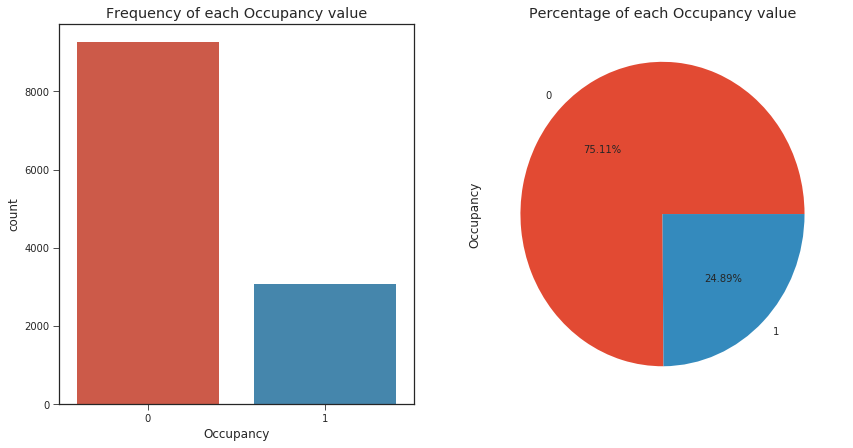

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14,7))
sns.countplot(x=PD_TARGET_VARIABLE_COLUMN_NAME, data=data_train, ax=axs[0])
axs[0].set_title("Frequency of each {} value".format(PD_TARGET_VARIABLE_COLUMN_NAME))
data_train[PD_TARGET_VARIABLE_COLUMN_NAME].value_counts().plot(x=None,y=None, kind='pie', ax=axs[1], autopct='%1.2f%%')
axs[1].set_title("Percentage of each {} value".format(PD_TARGET_VARIABLE_COLUMN_NAME))
plt.show()

## Проверим корреляцию признаков

In [12]:
data_train.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.049097,0.655458,0.597588,0.323295,0.524851
Humidity,-0.049097,1.000000,0.097879,0.444851,0.927516,0.188871
Light,0.655458,0.097879,1.000000,0.685222,0.338397,0.908617
CO2,0.597588,0.444851,0.685222,1.000000,0.662796,0.711089
HumidityRatio,0.323295,0.927516,0.338397,0.662796,1.000000,0.383737
Occupancy,0.524851,0.188871,0.908617,0.711089,0.383737,1.000000


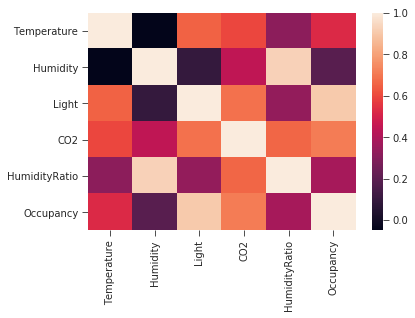

In [13]:
sns.heatmap(data_train.corr())

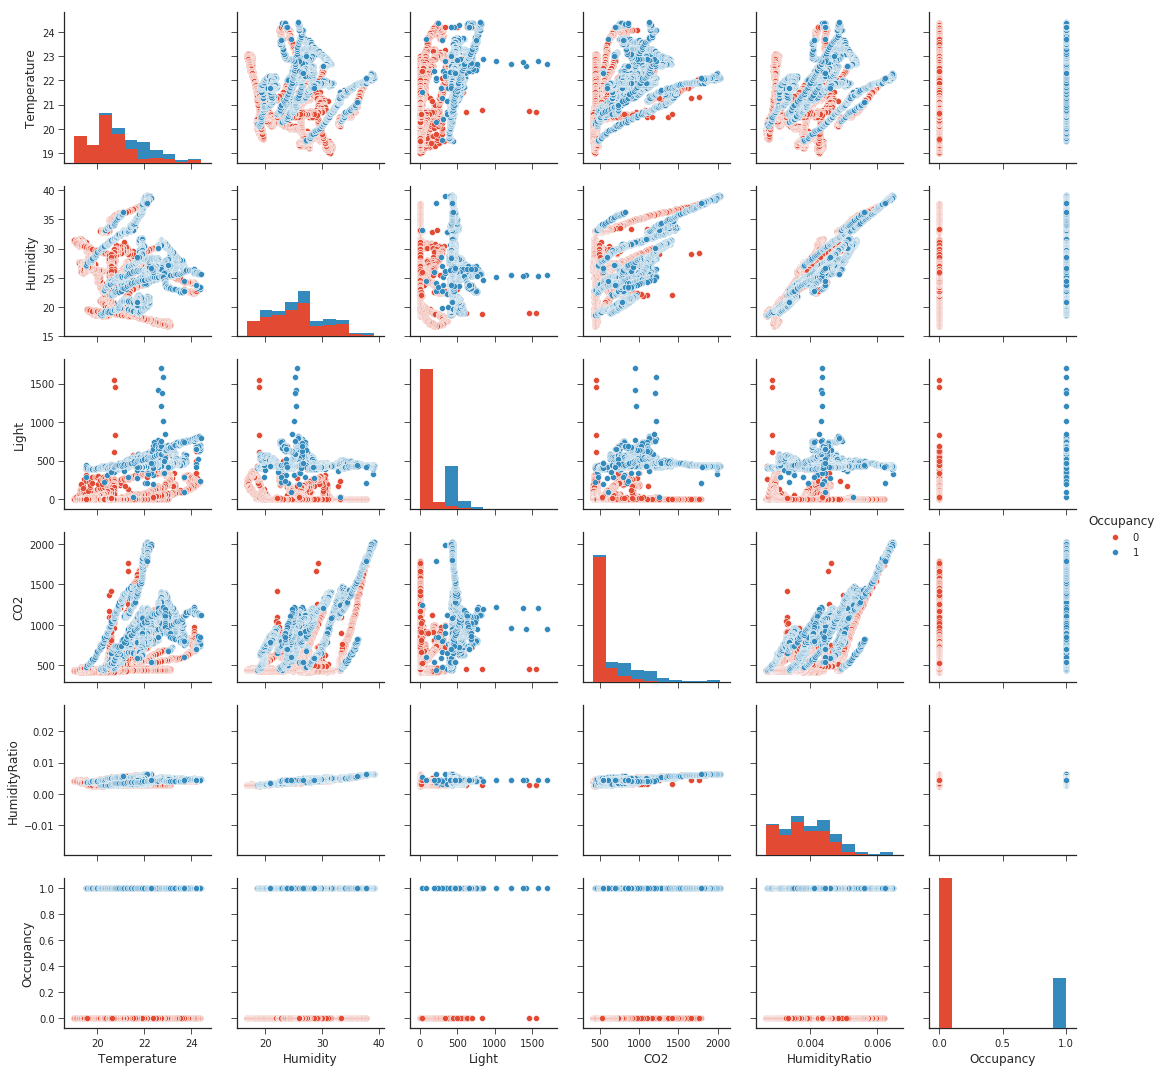

In [14]:
sns.pairplot(data_train, hue=PD_TARGET_VARIABLE_COLUMN_NAME)

### Проверим наличие незаполненных элементов и узнаем их количество:

In [15]:
data_train.isnull().values.any()

False

### Выделим лучшие признаки:

In [16]:
best_features = ['Temperature', 'Light', 'CO2', 'HumidityRatio']
# best_features = ['Temperature', 'Light', 'CO2']

### Удалим дублирующиеся строки:

In [17]:
# data_train = data_train.drop_duplicates(subset=best_features, keep='first')

### Для удобства  будем отдельно рассматривать столбцы, соответствующие входным признакам (матрица X), а отдельно – выделенный признак (вектор y):

In [18]:
X = data_train[best_features]
y = data_train[PD_TARGET_VARIABLE_COLUMN_NAME]

In [19]:
X.shape

(12336, 4)

In [20]:
y.shape

(12336,)

# Обучающая и тестовая выборки
### Разобьём данные на обучающую/тестовую выборки в отношении 80% : 20%:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = SKLEARN_TEST_SPLIT_TEST_SIZE,
                                                    random_state = SKLEARN_TEST_SPLIT_RANDOM_STATE)

# Обучение модели из sklearn 

### Вспомогательная функция для тестирования модели:

In [22]:
def test_model(model, X, y_true):
    y_predicted = model.predict(X)
    return accuracy_score(y_predicted, y_true)

In [23]:
model = LogisticRegression()
%time model.fit(X_train, y_train)

CPU times: user 107 ms, sys: 1.27 ms, total: 108 ms
Wall time: 110 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
acc_train = test_model(model, X_train, y_train)
acc_train

0.98652209160924198

In [25]:
acc_test = test_model(model, X_test, y_test)
acc_test

0.98581847649918963

In [26]:
my_model = DecisionTreeClassifier(min_samples_split=25, max_features=3, random_state=SKLEARN_TEST_SPLIT_RANDOM_STATE)
%time my_model.fit(X_train, y_train)

CPU times: user 41.4 ms, sys: 41.7 ms, total: 83.2 ms
Wall time: 30.8 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=25, min_weight_fraction_leaf=0.0,
            presort=False, random_state=4, splitter='best')

In [27]:
acc_train = test_model(my_model, X_train, y_train)
acc_train

0.99300770166193753

In [28]:
acc_test = test_model(my_model, X_test, y_test)
acc_test

0.98946515397082657

In [29]:
def test_model_auc(model, X, y):
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    return auc(false_positive_rate, true_positive_rate)

In [30]:
from matplotlib.legend_handler import HandlerLine2D

In [31]:
def plot_score_graph(x_ticks_count, train_results, test_results, metrics_name, model_param_name):
    line1, = plt.plot(x_ticks_count, train_results, 'b', label="Train ACC")
    line2, = plt.plot(x_ticks_count, test_results, 'r', label="Test ACC")

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

    plt.ylabel(metrics_name)
    plt.xlabel(model_param_name)
    plt.show()

### max_depth

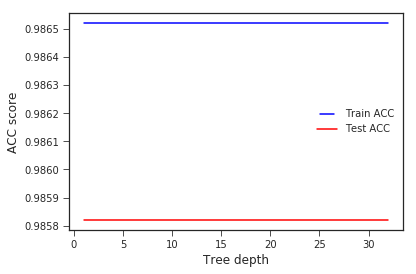

In [32]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=SKLEARN_TEST_SPLIT_RANDOM_STATE)
    classifier.fit(X_train, y_train)
    
    acc_train = test_model(model, X_train, y_train)
    train_results.append(acc_train)
    
    acc_test = test_model(model, X_test, y_test)
    test_results.append(acc_test)

plot_score_graph(max_depths, train_results, test_results, 'ACC score', 'Tree depth')

### min_samples_splits

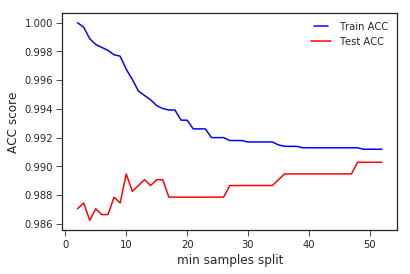

In [33]:
min_samples_splits = np.linspace(2, 52, 50, endpoint=True, dtype='int')

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=SKLEARN_TEST_SPLIT_RANDOM_STATE)
    model.fit(X_train, y_train)
    
    acc_train = test_model(model, X_train, y_train)
    train_results.append(acc_train)
    
    acc_test = test_model(model, X_test, y_test)
    test_results.append(acc_test)

plot_score_graph(min_samples_splits, train_results, test_results, 'ACC score', 'min samples split')

In [34]:
max(test_results)

0.99027552674230146

In [35]:
max_mae, idx = max((val, idx) for (idx, val) in enumerate(test_results))

### min_samples_leaf

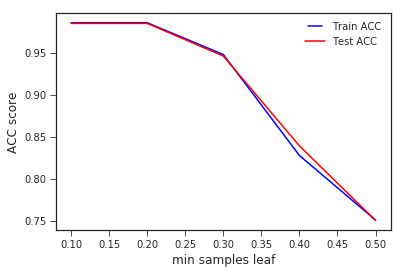

In [36]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=SKLEARN_TEST_SPLIT_RANDOM_STATE)
    model.fit(X_train, y_train)

    acc_train = test_model(model, X_train, y_train)
    train_results.append(acc_train)
    
    acc_test = test_model(model, X_test, y_test)
    test_results.append(acc_test)

from matplotlib.legend_handler import HandlerLine2D

plot_score_graph(min_samples_leafs, train_results, test_results, 'ACC score', 'min samples leaf')

### max_features

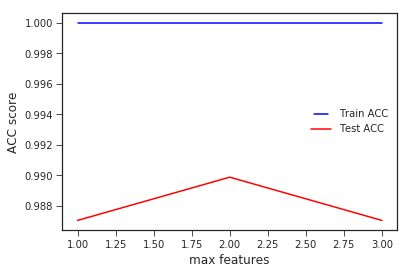

In [37]:
max_features = list(range(1, X.shape[1]))

train_results = []
test_results = []
for max_feature in max_features:
    model = DecisionTreeClassifier(max_features=max_feature, random_state=SKLEARN_TEST_SPLIT_RANDOM_STATE)
    model.fit(X_train, y_train)

    acc_train = test_model(model, X_train, y_train)
    train_results.append(acc_train)
    
    acc_test = test_model(model, X_test, y_test)
    test_results.append(acc_test)
    
plot_score_graph(max_features, train_results, test_results, 'ACC score', 'max features')

In [38]:
data_test.isnull().values.any()

False

In [39]:
X_final_test = data_test[best_features]

In [40]:
occupancy_predicted = my_model.predict(X_final_test)

In [41]:
data_test['value'] = occupancy_predicted
data_test.to_csv('base_solution.csv')

## Реализация   логистической регрессии

In [42]:
class LogRegression:
    """Логистическая регрессия."""
    def __init__(self, add_intercept=False):
        self.w = []
        self.add_intercept = add_intercept
    
    def _sigmoid(self, scores):
        return 1 / (1 + np.exp(-scores))
    
    def _log_likelihood(self, X, y):
        scores = np.dot(X, self.w)
        ll = np.sum(y * scores - np.log(1 + np.exp(scores)) )
        return ll
    
    def _predict(self, X):
        return self._sigmoid(np.dot(X, self.w))
    
    def fit(self, X, y, iters=300000, learning_rate=5e-5):
        if self.add_intercept:
            intercept = np.ones((X.shape[0], 1))
            X = np.hstack((intercept, X))
        
        self.w = np.zeros(X.shape[1])
    
        for step in range(iters):
            predictions = self._predict(X)

            # Update weights with gradient
            output_error_signal = y - predictions
            gradient = np.dot(X.T, output_error_signal)
            self.w += learning_rate * gradient
        
            # Print log-likelihood every so often
            if step % 10000 == 0:
                print (self._log_likelihood(X, y))
    
    def predict(self, X):
        if self.add_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.round(self._predict(X))

In [43]:
my_model = LogRegression(add_intercept=True)
%time my_model.fit(X_train, y_train, iters = 3000, learning_rate = 5e-5)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


-inf
CPU times: user 12.6 s, sys: 12.6 s, total: 25.2 s
Wall time: 6.9 s


In [45]:
acc_train = test_model(my_model, X_test, y_test)
acc_train

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


0.81888168557536467